In [186]:

# %pip install wordcloud
# %pip install praw

In [187]:
shoe_brand = 'Converse'

In [188]:
import pandas as pd
import numpy as np

# misc
import datetime as dt
from pprint import pprint
from itertools import chain

# reddit crawler
import praw

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

In [189]:
nltk.download('vader_lexicon') # get lexicons data
nltk.download('punkt') # for tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cjong\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cjong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cjong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [190]:
r = praw.Reddit(client_id='GJtzNYyCMIW-66t_xry24Q',
                     client_secret='ClyB_Id7qbhShlg4P43xqrLiyXPvyA',
                     user_agent='ljx597620034')

In [191]:
subreddit = r.subreddit(shoe_brand)

shoes_subreddit_top_posts = [*subreddit.top(limit=None)] # top posts all time

print(len(shoes_subreddit_top_posts))

999


In [192]:
shoes0 = shoes_subreddit_top_posts[0]

# pprint(vars(news0)) 
print(shoes0.title) # headline
print(shoes0.score) # upvotes
print(shoes0.created) # UNIX timestamps 
print(dt.datetime.fromtimestamp(shoes0.created)) # date and time
print(shoes0.num_comments) # no. of comments
print(shoes0.upvote_ratio) # upvote / total votes
print(shoes0.total_awards_received) # no. of awards given

I’m in too deep
429
1595007114.0
2020-07-17 13:31:54
44
1.0
1


In [193]:
title = [i.title for i in shoes_subreddit_top_posts]
score = [i.score for i in shoes_subreddit_top_posts]
shoes = pd.DataFrame({
    "title": title,
    "score": score,
})
shoes.head()

,title,score
0,I’m in too deep,429
1,Why choose?,410
2,Cyberpunk 2077 inspired chucks,401
3,When I was a kid I loved Elvis and always want...,381
4,I made these!,376


In [194]:
sid = SentimentIntensityAnalyzer()

In [195]:
res = [*shoes['title'].apply(sid.polarity_scores)]
pprint(res[:3])

[{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.4939, 'neg': 0.0, 'neu': 0.484, 'pos': 0.516}]


In [196]:
sentiment_df = pd.DataFrame.from_records(res)

shoes = pd.concat([shoes, sentiment_df], axis=1, join='inner')
shoes.head()

,title,score,neg,neu,pos,compound
0,I’m in too deep,429,0.0,1.000,0.000,0.0000
1,Why choose?,410,0.0,1.000,0.000,0.0000
2,Cyberpunk 2077 inspired chucks,401,0.0,0.484,0.516,0.4939
3,When I was a kid I loved Elvis and always want...,381,0.0,0.843,0.157,0.5994
4,I made these!,376,0.0,1.000,0.000,0.0000


In [197]:
# # weighin the sentiment score absded on the post scores

# shoes['neg'] = shoes['neg'] * shoes['score']
# shoes['neu'] = shoes['neu'] * shoes['score']
# shoes['pos'] = shoes['pos'] * shoes['score']

In [198]:
THRESHOLD = 0.4

conditions = [
    (shoes['compound'] <= -THRESHOLD),
    (shoes['compound'] > -THRESHOLD) & (shoes['compound'] < THRESHOLD),
    (shoes['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
shoes['label'] = np.select(conditions, values)

shoes.head()

,title,score,neg,neu,pos,compound,label
0,I’m in too deep,429,0.0,1.000,0.000,0.0000,neu
1,Why choose?,410,0.0,1.000,0.000,0.0000,neu
2,Cyberpunk 2077 inspired chucks,401,0.0,0.484,0.516,0.4939,pos
3,When I was a kid I loved Elvis and always want...,381,0.0,0.843,0.157,0.5994,pos
4,I made these!,376,0.0,1.000,0.000,0.0000,neu


In [199]:
sentence0 = shoes.title.iloc[0]
print(sentence0)
words0 = shoes.title.iloc[0].split()
print(words0)

pos_list, neg_list, neu_list = [], [], []

for word in words0: 
    if (sid.polarity_scores(word)['compound']) >= THRESHOLD:
        pos_list.append(word)
    elif (sid.polarity_scores(word)['compound']) <= -THRESHOLD:
        neg_list.append(word)
    else:
        neu_list.append(word)                


I’m in too deep
['I’m', 'in', 'too', 'deep']


In [200]:

print('\nPositive:',pos_list)        
print('Neutral:',neu_list)    
print('Negative:',neg_list) 
score = sid.polarity_scores(sentence0)



Positive: []
Neutral: ['I’m', 'in', 'too', 'deep']
Negative: []


In [201]:

print(f"\nThis sentence is {round(score['neg'] * 100, 2)}% negative")
print(f"This sentence is {round(score['neu'] * 100, 2)}% neutral")
print(f"This sentence is {round(score['pos'] * 100, 2)}% positive")



This sentence is 0.0% negative
This sentence is 100.0% neutral
This sentence is 0.0% positive


In [202]:
score

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [203]:
type(score['compound'])

float

In [204]:
type(THRESHOLD)
t1 =score['compound']
t2 =THRESHOLD
t3 = t1 <= t2
t3
# temp = t2<=(t1<={t2})

True

In [205]:

if score['compound'] >= THRESHOLD:
    print(f"The compound value : {score['compound']} >= {THRESHOLD}")
    print(f"\nThis sentence is positive")
elif score['compound'] <= -THRESHOLD:
    print(f"\nThis sentence is negative")
    print(f"The compound value : {score['compound']} <= {-THRESHOLD}")
else:
    print(f"\nThis sentence is neutral")


This sentence is neutral


In [206]:
shoes.label.value_counts()

neu    634
pos    327
neg     38
Name: label, dtype: int64

In [207]:
total_score = pd.DataFrame.sum(shoes.pos)-pd.DataFrame.sum(shoes.neg)
total_score

126.846

In [208]:
lst2 = []
pos1 = pd.DataFrame.sum(shoes.pos)
neu1 = pd.DataFrame.sum(shoes.neu)
neg1 = pd.DataFrame.sum(shoes.neg)

In [209]:
lst2.append(pos1)
lst2.append(neu1)
lst2.append(neg1)

In [210]:
print(lst2)

[154.436, 814.967, 27.589999999999996]


<AxesSubplot:>

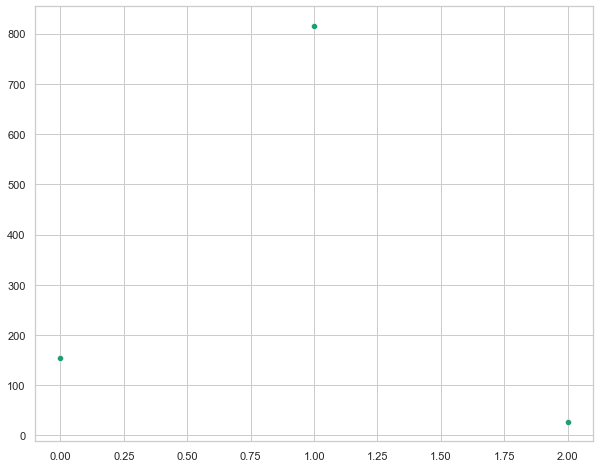

In [211]:
sns.scatterplot(data=lst2)  


In [212]:
shoes.label

0      neu
1      neu
2      pos
3      pos
4      neu
      ... 
994    neu
995    pos
996    pos
997    neu
998    pos
Name: label, Length: 999, dtype: object

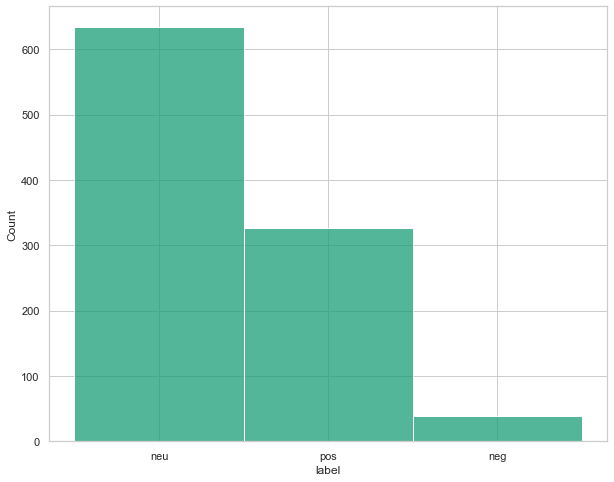

In [213]:
sns.histplot(shoes.label);

In [214]:
def shoes_title_output(df, label):
  res = df[df['label'] == label].title.values
  print(f'{"=" * 20}')
  print("\n".join(title for title in res))

# randomly sample
shoes_sub = shoes.groupby('label').sample(n = 5, random_state = 7)

print("Positive news")
shoes_title_output(shoes_sub, "pos")

print("\nNeutral news")
shoes_title_output(shoes_sub, "neu")

print("\nNegative news")
shoes_title_output(shoes_sub, "neg")

Positive news
Chuck 70s Black/egret high tops. These are slowly becoming my favorites.
Got these with %50 off on Black Friday. In love with the patch details.
Just bought Chuck 70 Thermo Felt and it looks so nice!
They either support pride or the NHS, either way they look great.
My new Converse arrived today. I love them.

Neutral news
After buying 20+ pairs, I promised myself (and my gf) I wouldn't buy any more Converse this year... then Black Friday happened
Here's my "small" collection
The most important things for traveling
Today I hit 25 pairs. I blame lockdown.
One of my weirder pairs, they’re made entirely out of rubber (kinda like rain boots, but converse)

Negative news
Your eyes aren’t deceiving you. These really are that green. I need more monochrome pairs!
The only reason Will Smith was able to kill all those robots
Sitting in class, getting an itchy foot.."oh yea, those two weird holes.." genius, Converse.
A gal could have worse problems.
got these bad boys for christmas a

In [215]:
stop_words = stopwords.words('english')
def custom_tokenize(text): 
  # remove single quote and dashes
    text = text.replace("'", "").replace("-", "").lower()

  # split on words only 
    tk = nltk.tokenize.RegexpTokenizer(r'\w+')  
    tokens = tk.tokenize(text)
    

  # remove stop words
    words = [w for w in tokens if not w in stop_words] 
    return words

In [216]:
def tokens_2_words(df, label):
  # subset titles based on label
    titles = df[df['label'] == label].title
  # apply our custom tokenize function to each title
    tokens = titles.apply(custom_tokenize)
  # join nested lists into a single list
    words = list(chain.from_iterable(tokens))
    return words

pos_words = tokens_2_words(shoes, 'pos')
neg_words = tokens_2_words(shoes, 'neg')

In [217]:
pos_freq = nltk.FreqDist(pos_words)
pos_freq.most_common(20)

[('converse', 67),
 ('love', 67),
 ('pair', 63),
 ('first', 43),
 ('chuck', 38),
 ('new', 37),
 ('got', 36),
 ('chucks', 31),
 ('happy', 28),
 ('day', 26),
 ('like', 24),
 ('today', 24),
 ('70s', 20),
 ('high', 18),
 ('tops', 18),
 ('70', 16),
 ('favorite', 16),
 ('shoes', 15),
 ('custom', 15),
 ('pairs', 15)]

In [218]:
pos_im = [str(p) for p in pos_words] 
pos_str = ",".join(pos_im) 
neg_im = [str(p) for p in neg_words] 
neg_str = ",".join(neg_im)

<function matplotlib.pyplot.show(close=None, block=None)>

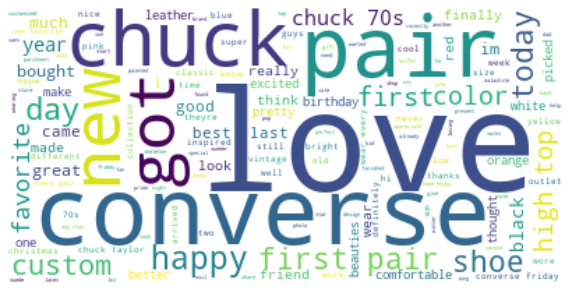

In [219]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

word_cloud_pos = WordCloud(background_color = "white").generate(pos_str)
word_cloud_neg = WordCloud().generate(neg_str)
plt.imshow(word_cloud_pos,interpolation = "bilinear") 
plt.axis("off") 
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

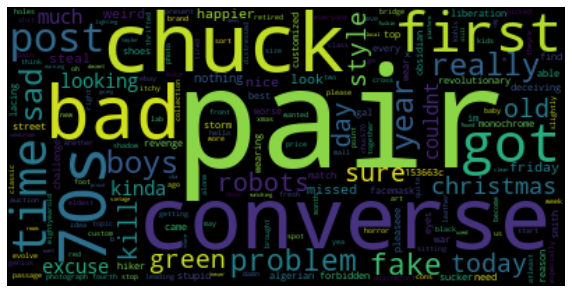

In [220]:
plt.imshow(word_cloud_neg,interpolation = "bilinear") 
plt.axis("off") 
plt.show